In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pylab as plt
from matplotlib import cm
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns

#  Functions

In [295]:
def load_data(file_name):
    '''
    This function loads the data and does ann initial clean
    
    It takes an input string for the file name
    
    Outputs a series of 4 criteria
    '''
    
    xl_file = pd.ExcelFile(file_name)
    dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

    #Save DF for each course
    df_SC = dfs['SC Report']
    df_T = dfs['T Report']
    df_SA = dfs['SA Report']
    df_MT = dfs['MT Report']
    
    #Adjusting the headers 
    df_SC.columns = df_SC.iloc[[4]].values[0]
    df_SC.drop(df_SC.index[0:5],inplace=True)

    #Adjusting the headers 
    df_T.columns = df_T.iloc[[4]].values[0]
    df_T.drop(df_T.index[0:5],inplace=True)

    #Adjusting the headers 
    df_SA.columns = df_SA.iloc[[4]].values[0]
    df_SA.drop(df_SA.index[0:5],inplace=True)

    #Adjusting the headers 
    df_MT.columns = df_MT.iloc[[4]].values[0]
    df_MT.drop(df_MT.index[0:5],inplace=True)
    
    try:
        df_SC.drop('Zone',axis=1,inplace=True)
        df_SA.drop('Zone',axis=1,inplace=True)
        df_T.drop('Zone',axis=1,inplace=True)
        df_MT.drop('Zone',axis=1,inplace=True)
        print 'dropping the Zone column'
    except:
        pass
    
    #Drop common surplus headers #dec16 #
    surplus_headers_SC = df_SC.columns[5:13]
    surplus_headers_T = df_T.columns[5:11]
    surplus_headers_SA = df_SA.columns[5:12]
    surplus_headers_MT = df_MT.columns[5:12]

    df_SC.drop(surplus_headers_SC,1,inplace=True)
    df_T.drop(surplus_headers_T,1,inplace=True)
    df_SA.drop(surplus_headers_SA,1,inplace=True)
    df_MT.drop(surplus_headers_MT,1,inplace=True)
    
    
    return df_SC,df_T,df_SA,df_MT

In [228]:
def aggregate_course(df,c,o):
    '''
    This function cleans up the data for a given accreditation criteria.
    Valuing completed coures as 1, Pending Approval as 0.9 and booked courses and 0.5. 
    Each course is weighted by the total number for that criteria and summed to give a fraction.
    The DataFrame is then update.
    
    input:
    df = the Dataframe to be updated
    c = column index number from which to start aggregation (6 jan2017, 5 dec2016)
    o = column index for ommission of unaccessed course
    '''
    #replace categoricals with numeric values
    df.replace('Complete',1.0,inplace=True)
    df.replace('Pending Approval',0.9,inplace=True)
    df.replace('Booked',0.5,inplace=True)
    df.fillna(0,inplace=True)
    #Drop the 'unreleased column'
    df.drop(df.columns[-o:],axis=1,inplace=True)

    #wieghting
    total_course_fraction = []
    total_course_completion = []
    l = len(df)
    
    for i in range(l):
        course_completion = df.iloc[[i]].values[0][c:]
        course_fraction = sum(map(lambda x: x/len(course_completion), course_completion))
        total_course_fraction.append(course_fraction)
        if course_fraction > 0.999:
            total_course_completion.append(1)
        else:
            total_course_completion.append(0)

    #Update Dataframe
    df['Total fraction'] = pd.Series(total_course_fraction, index=df.index)
    df['Total completion'] = pd.Series(total_course_completion, index=df.index)
    
    return df


#aggregate_course(df_SC,6,3)


In [3]:
def course_completion(dealers,criteria):
    '''
    Count people who completed the criteria and calculation a dealership completion fraction
    
    Calculate:
    a) the number of people on the course, 
    b) number of completions on the course,
    c) fraction of people who have completed across a dealer.
    '''

    total_completion_dict = {}
    total_completion_results = []

    for i in dealers:
        people_total = 0
        completed_total = 0
        for j in criteria:
            try:
                dg = j.groupby('Code').get_group(i)
                people = len(dg['Total completion'])
                completed = len(dg.loc[dg['Total completion'] == 1.0])
                completion_frac = round(float(completed)/float(people),2)
            except:
                people = 0
                completed = 0
                completion_frac = np.nan
            
            total_completion_results.append(completion_frac)
            people_total = people_total + people
            completed_total = completed_total + completed
        
        total_completion_results.append(round(np.nansum(float(completed_total))/np.nansum(float(people_total)),2))
        total_completion_dict[i] = total_completion_results
        total_completion_results = []

    #Produce DataFrame with results    
    df_completion = pd.DataFrame(data=total_completion_dict)
    df_completion = df_completion.T
    df_completion.columns=['MT','SC','SA','T','All']
    return df_completion

In [98]:
def course_progress(dealers,criteria):
    '''
    Find the mean course completion fraction, per criteria, per dealership
    
    Calculates:
    a) the mean completion fraction for staff of a given criteria, per dealership
    b) the mean completion of all staff in a dealership
    '''
    mean_list = []
    std_list = []
    sum_list = []
    mean_dict = {}
    std_dict = {}
    grand_mean_list = []

    for i in dealers:
        #print i
        for j in criteria:
            try:
                dg = j.groupby('Code').get_group(i)
                #print dg['Total fraction'].values, np.mean(dg['Total fraction'].values)
                mean = round(np.mean(dg['Total fraction'].values),4)
                std = round(np.std(dg['Total fraction'].values/np.sqrt(len(dg['Total fraction'].values))),4)
                sums = np.nansum(dg['Total fraction'].values)
                mean_list.append(mean)
                std_list.append(std)
                grand_mean_list.append(dg['Total fraction'].values)
            except:
                mean_list.append(np.nan)
                std_list.append(np.nan)
        
        #print mean_list
        dealer_mean = np.nanmean(np.concatenate(grand_mean_list))
        dealer_std = np.nanstd(np.concatenate(grand_mean_list))/np.sqrt(len(np.concatenate(grand_mean_list)))
        mean_list.append(round(dealer_mean,4))
        std_list.append(round(dealer_std,4))
        sum_list.append(sums)
        mean_dict[i] = mean_list
        std_dict[i] = std_list
        mean_list = []
        std_list = []
        grand_mean_list = []

    df_progress = pd.DataFrame(data=mean_dict)
    df_progress = df_progress.T
    df_progress.columns=['MT','SC','SA','T','ALL']
    
    df_progress_std = pd.DataFrame(data=std_dict)
    df_progress_std = df_progress_std.T
    df_progress_std.columns=['MT','SC','SA','T','ALL']
    return df_progress, df_progress_std


df_progress, df_progress_std = course_progress(dealers,criteria)#
print df_progress.ix[1651]
print df_progress_std.ix[1651]

MT     0.7500
SC     0.9977
SA     0.7151
T      0.4964
ALL    0.7423
Name: 1651, dtype: float64
MT     0.0707
SC     0.0021
SA     0.1866
T      0.0940
ALL    0.0676
Name: 1651, dtype: float64


In [ ]:
df_SC.groupby('Code').get_group(1651)

# Load data

In [ ]:
#Load target data
targets = 'West_Way_Accreditation/FY16 West Way Dealer Accreditation Targets.xlsx'

xl_file = pd.ExcelFile(targets)
dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

#Save DF for each course
df_targets = dfs['FY16 Targets']
df_targets.fillna(0,inplace=True)

In [305]:
#Load staff data - jan 2016
file_name = 'West_Way_Accreditation/20170106 FY16 West Way Accreditation Report.xlsx'

df_SC,df_T,df_SA,df_MT = load_data(file_name)

dropping the Zone column


In [299]:
#Load staff data
file_name = 'West_Way_Accreditation/20161207 FY16 West Way Accreditation Report.xlsx'

df_SC,df_T,df_SA,df_MT = load_data(file_name)

In [160]:
#Reduce to F2F only
#df_SC_F2F = df_SC.drop(df_SC.columns[12:25],1).drop(df_SC.drop(df_SC.columns[12:25],1).columns[15:],1)
#df_T_F2F = df_T.drop(df_T.columns[6:],1)
#df_SA_F2F = df_SA.drop(df_SA.columns[10:24],1).drop(df_SA.drop(df_SA.columns[10:24],1).columns[11:],1)
#df_MT_F2F = df_MT.drop(df_MT.columns[8:16],1).drop(df_MT.drop(df_MT.columns[8:16],1).columns[9:],1)

In [161]:
#Reduce to Initial only
#df_SC_init = df_SC[df_SC.columns[0:25]]
#df_T_init = df_T[df_T.columns[0:13]]
#df_SA_init = df_SA[df_SA.columns[0:24]]
#df_MT_init = df_MT[df_MT.columns[0:16]]

In [293]:
df_SC.head(1)

,Username,First Name,Last Name,Code,Dealership,N-GAGE Sales Consultant TNA,Nissan Sales 1,Nissan Sales 2,Added Value Sales,VCT: The Nissan Brand,...,VCT: Delivering the Customer Promise,NSSW e-Learning,Sales NSSW: Customer Quality in Action,Nissan Accessories and Personalisation,Nissan Warranty for Sales,Quality: Approaching the Customer,Quality: Handover,Quality: Mindfulness at Work,All New Micra Part 1,FY16 Sales Consultant Knowledge Retention Assessment (coming soon)
5,228112,Stephen,Duffy,1525,1525 West Way Basingstoke,Complete,Complete,Complete,Complete,Complete,...,Complete,Complete,0,0,0,0,0,0,Complete,NaN


# Analysis

In [307]:
df_SC.columns

Index([                                                     u'Username',
                                                          u'First Name',
                                                           u'Last Name',
                                                                u'Code',
                                                         u'Dealership ',
                                         u'N-GAGE Sales Consultant TNA',
                                                     u'Nissan Sales 1 ',
                                                      u'Nissan Sales 2',
                                                  u'Added Value Sales ',
                                              u'VCT: The Nissan Brand ',
                                               u'VCT: Market Awareness',
       u'VCT: Selling Nissan Accessories, Personalisation and Warranty',
                                        u'You+Nissan Customer Promise ',
                                                   

In [306]:
#Full DataSet
#dec16=5
#jan17=6
c = 6

df_SC = aggregate_course(df_SC,c,3)
df_T = aggregate_course(df_T,c,1)
df_SA = aggregate_course(df_SA,c,1)
df_MT = aggregate_course(df_MT,c,1)

In [304]:
#Save 2016 data
df_SC_dec16 = df_SC
df_T_dec16 = df_T
df_SA_dec16 = df_SA
df_MT_dec16 = df_MT

In [308]:
#deffine dealers    
dealership_names = {1525:'Basingstoke',1533:'Southampton',1535:'Aldershot',
                    1633:'Coventry',1650:'Birmingham',1651:'Stourbridge',
                    1655:'Wolverhampton',1692:'Stockport',1693:'Rochdale',
                    1694:'Oldham',1708:'Manchester',1877:'Hanwell',
                    1878:'Mill Hill',1883:'Altrincham'}

dealers = sorted(dealership_names.iterkeys())

In [309]:
#Deffine the criteria - jan2017
criteria = [df_MT,df_SC,df_SA,df_T]
df_completion = course_completion(dealers,criteria)
df_progress, df_progress_std = course_progress(dealers,criteria)

#Deffine the criteria - dec2016
criteria_dec16 = [df_MT_dec16,df_SC_dec16,df_SA_dec16,df_T_dec16]
df_completion_dec16 = course_completion(dealers,criteria_dec16)
df_progress_dec16, df_progress_std_dec16 = course_progress(dealers,criteria_dec16)

In [218]:
df_SC.groupby('Code').get_group(1651)

,Username,First Name,Last Name,Zone,Code,Dealership,N-GAGE Sales Consultant TNA,Nissan Sales 1,Nissan Sales 2,Added Value Sales,...,Nissan Accessories and Personalisation,Nissan Warranty for Sales,Quality: Approaching the Customer,Quality: Handover,Quality: Mindfulness at Work,All New Micra Part 1,All New Micra Strategy - Part 2,All New Micra Essentials - Part 3,Total fraction,Total completion
36,231042,Zac,Berlyn,S5,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.935484,0
46,231594,Martyn,Taylor,S5,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.935484,0
51,231925,Jonathan,Goddard,S5,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.935484,0
57,231924,Matthew,Green,S5,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.935484,0
65,228391,Derek,Fardy,S5,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.935484,0
70,230570,Matthew,Smith,S5,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.935484,0
73,226348,Ian,Woodier,S5,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.935484,0


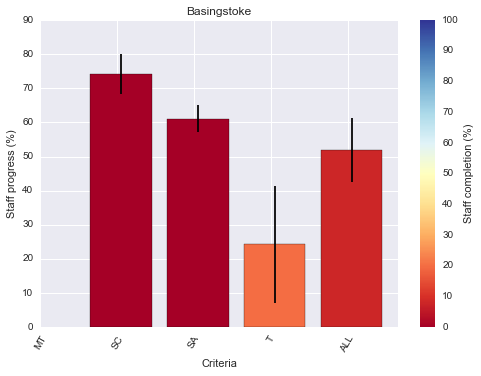

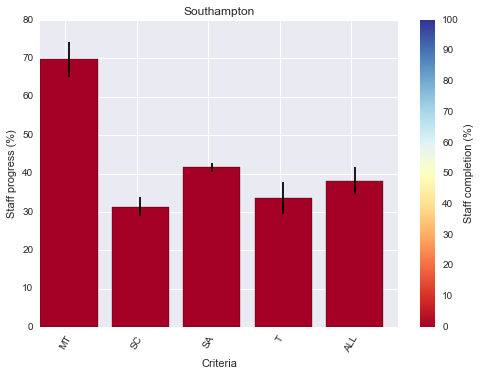

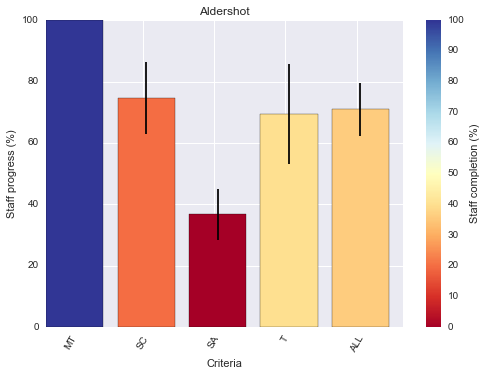

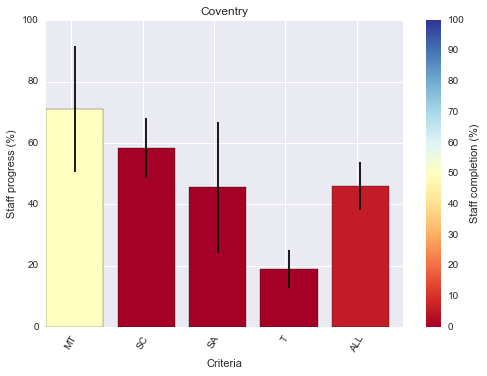

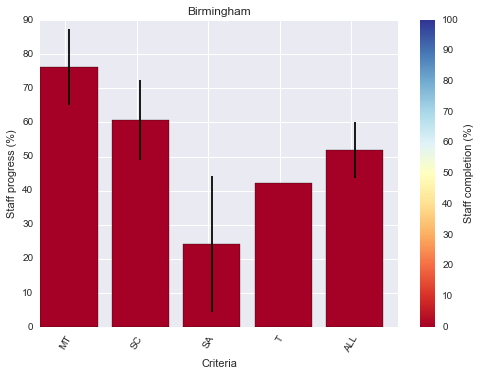

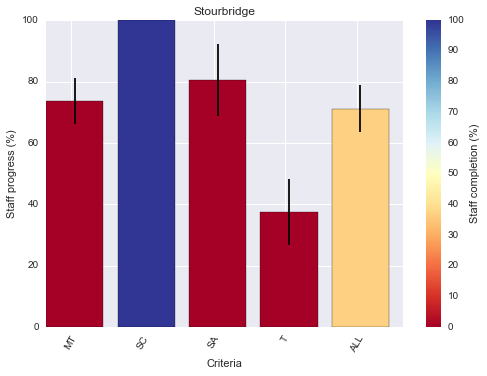

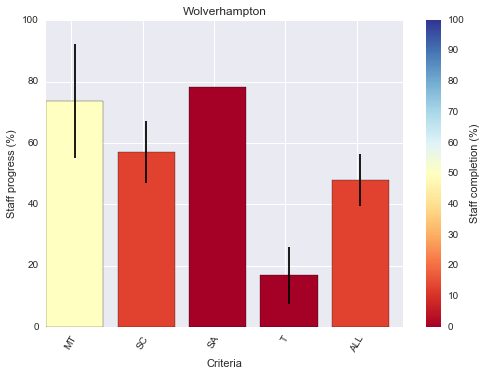

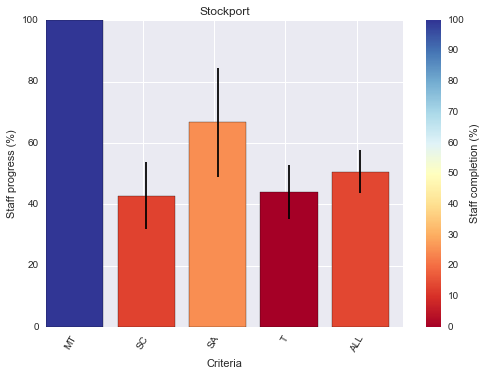

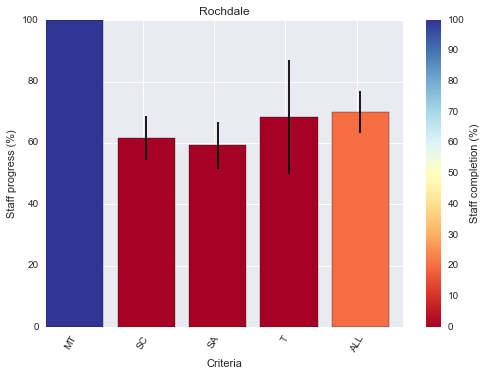

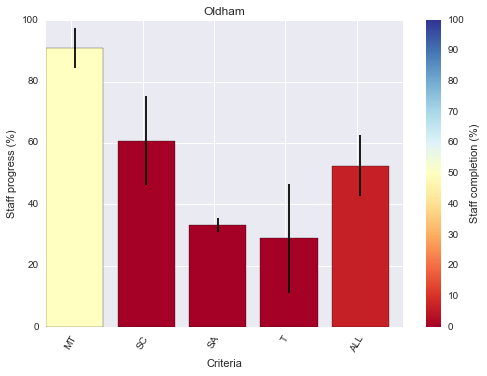

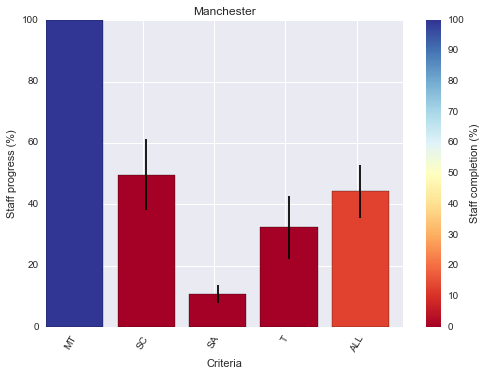

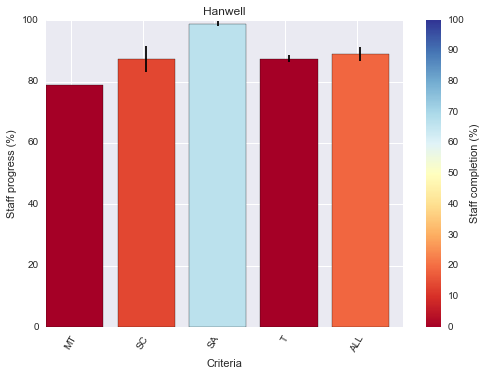

In [310]:
def PLOT_bar_chart(df_A,df_A_std,df_B,i):
    '''
    Plot the 4 criteria and combined scores for a dealership with a colour gradient
    
    '''   
    plt.figure()

    x = df_A.columns
    dy = map(lambda x:100.*x,df_A_std.iloc[i])
    y = map(lambda x:100.*x,df_A.iloc[i])
    z = map(lambda x:100.*x,df_B.iloc[i])
    
    title = dealership_names[df_A.index[i]]
    
    plot = plt.scatter(z, z, c = z,vmin=0,vmax=100., cmap = 'RdYlBu')
    plt.clf()
    cb = plt.colorbar(plot)
    cb.set_label('Staff completion (%)')
    
    plt.bar(np.arange(len(y)),y,yerr=dy,color = cm.RdYlBu([i / 100. for i in z]),ecolor='k')

    plt.title('{}'.format(title))
    plt.ylabel('Staff progress (%)')
    plt.xlabel('Criteria')
    
    plt.xticks()
    plt.xticks(np.arange(len(y))+0.35,x,rotation=60)

    
    date = 'jan2017'
    plt.savefig("plots/{}/{}_progress_{}.pdf".format(date,title,date))
    
    #plt.show()
    
    return 


for i in range(12):
    PLOT_bar_chart(df_progress,df_progress_std,df_completion,i)

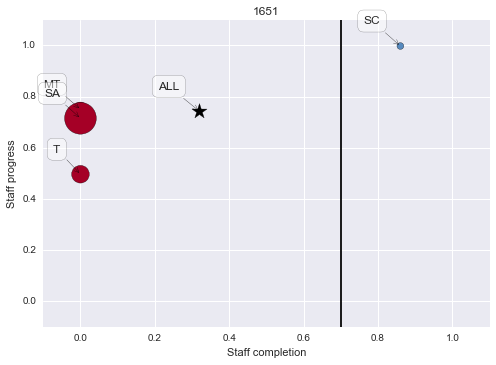

In [23]:
def PLOT_scatter_chart(df_A,df_Astd,df_B,i):
    '''
    Plot the 4 criteria and combined scores for a dealership with a colour gradient
    
    '''   
    plt.figure()

    x = df_A.columns
    y = df_A.iloc[i]
    s = df_Astd.iloc[i]
    z = df_B.iloc[i]
    #print y
    #print z
    
    title = df_A.index[i]

    plt.scatter(z[:-1], y[:-1], c = z[:-1], cmap = 'RdYlBu',vmin=0,vmax=1,s=[((i+0.1)*35)**3. for i in s])
    plt.scatter(z[-1:], y[-1:], marker='*',s=250,color='k')
    
    labels = ['{}'.format(i) for i in x]
    for label, posx, posy in zip(labels, z, y):
        plt.annotate(
            label,
            xy=(posx, posy), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
    plt.title('{}'.format(title))
    plt.ylabel('Staff progress')
    plt.xlabel('Staff completion')
    plt.axvline(x=0.7,color='k')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])

    plt.show()
    
    return 

PLOT_scatter_chart(df_progress,df_progress_std,df_completion,5)

1525 Basingstoke 0.5383
1533 Southampton 0.4004
1535 Aldershot 0.7196
1633 Coventry 0.4712
1650 Birmingham 0.529
1651 Stourbridge 0.7199
1655 Wolverhampton 0.4903
1692 Stockport 0.5131
1693 Rochdale 0.7127
1694 Oldham 0.5319
1708 Manchester 0.4615
1877 Hanwell 0.8941
1878 Mill Hill 0.4188
1883 Altrincham 0.6767
{'Southampton': 0.40039999999999998, 'Wolverhampton': 0.49030000000000001, 'Basingstoke': 0.5383, 'Stourbridge': 0.71989999999999998, 'Coventry': 0.47120000000000001, 'Oldham': 0.53190000000000004, 'Hanwell': 0.89410000000000001, 'Mill Hill': 0.41880000000000001, 'Birmingham': 0.52900000000000003, 'Altrincham': 0.67669999999999997, 'Manchester': 0.46150000000000002, 'Stockport': 0.5131, 'Rochdale': 0.7127, 'Aldershot': 0.71960000000000002}
['Southampton', 'Wolverhampton', 'Basingstoke', 'Stourbridge', 'Coventry', 'Oldham', 'Hanwell', 'Mill Hill', 'Birmingham', 'Altrincham', 'Manchester', 'Stockport', 'Rochdale', 'Aldershot']


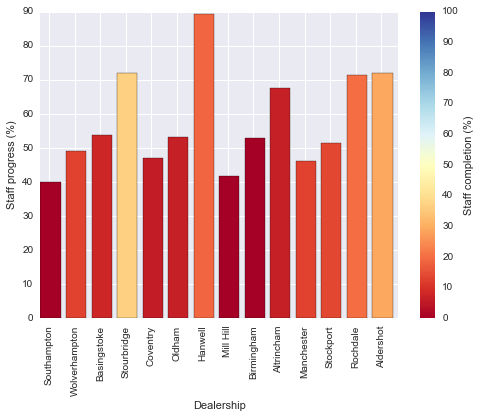

In [239]:
#Dealer overview plot

def dealer_overview(df_A,df_A_std,df_B):
    '''
    produce a plot displaying the 'ALL' column for all dealers on a single plot.
    '''
    progress_dict = {}
    progress_err_dict = {}
    completion_dict = {}
    
    x = []
    
    for i in sorted(dealership_names.keys()):
        print i,dealership_names[i],df_A.ix[i][4]
        progress_dict[dealership_names[i]] = df_A.ix[i][4]
        progress_err_dict[dealership_names[i]] = df_A_std.ix[i][4]
        completion_dict[dealership_names[i]] = df_B.ix[i][4]
        x.append(dealership_names[i])
        
    plt.figure()
    
    x = progress_dict.keys()
    
    print progress_dict#.values()
    print x
    
    y = [i*100. for i in progress_dict.values()]
    dy = [i*100. for i in progress_err_dict.values()]
    z = [i*100. for i in completion_dict.values()]
    
    #title = df_A.index[i]
    
    plot = plt.scatter(z, z, c = z,vmin=0,vmax=100, cmap = 'RdYlBu')
    plt.clf()
    cb = plt.colorbar(plot)
    cb.set_label('Staff completion (%)')
    
    plt.bar(np.arange(len(y)),y,color = cm.RdYlBu([i / 100. for i in z]))#,ecolor='k')
    
    #plt.title('{}'.format(title))
    plt.ylabel('Staff progress (%)')
    plt.xlabel('Dealership')
    
    plt.xticks()
    plt.xticks(np.arange(len(y))+0.35,x,rotation=90)
    
    date = 'jan2017'
    plt.savefig("plots/{}/Dealership_progress_{}.pdf".format(date,date))
    
    plt.show()   
    
    return

dealer_overview(df_progress,df_progress_std,df_completion)

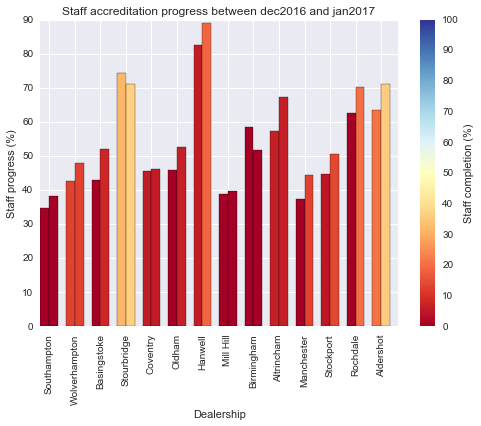

In [312]:
#Dealer overview plot

def dealer_overview_month(df_A1,df_B1,df_A2,df_B2):
    '''
    produce a plot displaying the 'ALL' column for all dealers on a single plot.
    '''
    progress_dict1 = {}
    progress_dict2 = {}
    completion_dict1 = {}
    completion_dict2 = {}
    w = 0.35
    
    for i in sorted(dealership_names.keys()):
        #print i,dealership_names[i],df_A1.ix[i][4],df_A2.ix[i][4]
        progress_dict1[dealership_names[i]] = df_A1.ix[i][4]
        progress_dict2[dealership_names[i]] = df_A2.ix[i][4]
        completion_dict1[dealership_names[i]] = df_B1.ix[i][4]
        completion_dict2[dealership_names[i]] = df_B2.ix[i][4]
        
    plt.figure()
    
    x = progress_dict1.keys()
    y1 = [i*100. for i in progress_dict1.values()]
    z1 = [i*100. for i in completion_dict1.values()]
    y2 = [i*100. for i in progress_dict2.values()]
    z2 = [i*100. for i in completion_dict2.values()]
        
    plot = plt.scatter(z1, z1, c = z1,vmin=0,vmax=100, cmap = 'RdYlBu')
    plt.clf()
    cb = plt.colorbar(plot)
    cb.set_label('Staff completion (%)')
    
    plt.bar(np.arange(len(y1)),y1,width=w,color = cm.RdYlBu([i / 100. for i in z1]))#,ecolor='k')
    plt.bar(np.arange(len(y2))+w,y2,width=w,color = cm.RdYlBu([i / 100. for i in z2]))#,ecolor='k')
    

    plt.ylabel('Staff progress (%)')
    plt.xlabel('Dealership')
    
    plt.xticks()
    plt.xticks(np.arange(len(y1))+w,x,rotation=90)
    
    date1 = 'dec2016'
    date2 = 'jan2017'
    plt.title('Staff accreditation progress between {} and {}'.format(date1,date2))
    plt.savefig("plots/Dealership_progress_{}_{}.pdf".format(date1,date2))
    
    plt.show()   
    
    return

dealer_overview_month(df_progress_dec16,df_completion_dec16,df_progress,df_completion)

In [320]:
df_T_dec16.groupby('Code').get_group(1651).iloc[0]#['Total fraction']

Username                                                                               231597
First Name                                                                             Thomas
Last Name                                                                              Ganner
Code                                                                                     1651
Dealership                                                          1651 West Way Stourbridge
Technician Induction                                                                        1
Nissan ESM                                                                                  1
Consult lll plus Basic Operation                                                            1
Nissan X-Trail Part 1                                                                       1
Nissan X-Trail Part 2                                                                       1
Nissan X-Trail Part 3                                       

In [319]:
df_T.groupby('Code').get_group(1651).iloc[0]#['Total fraction']

Username                                                                               231597
First Name                                                                             Thomas
Last Name                                                                              Ganner
Code                                                                                     1651
Dealership                                                          1651 West Way Stourbridge
Technician Induction                                                                        0
Nissan ESM                                                                                  0
Consult lll plus Basic Operation                                                            0
Nissan X-Trail Part 1                                                                       0
Nissan X-Trail Part 2                                                                       0
Nissan X-Trail Part 3                                       

In [256]:
print 'SC length: dec16 = ',len(df_SC_dec16.columns[5:]),', jan17 = ',len(df_SC.columns[6:])
print 'SA length: dec16 = ',len(df_SA_dec16.columns[5:]),', jan17 = ',len(df_SA.columns[6:])
print 'T length: dec16 = ',len(df_T_dec16.columns[5:]),', jan17 = ',len(df_T.columns[6:])
print 'MT length: dec16 = ',len(df_MT_dec16.columns[5:]),', jan17 = ',len(df_MT.columns[6:])

print '# technicians: dec2016 = ',len(df_T_dec16.groupby('Code').get_group(1651)),' jan2017 = ',len(df_T.groupby('Code').get_group(1651))

SC length: dec16 =  31 , jan17 =  31
SA length: dec16 =  33 , jan17 =  33
T length: dec16 =  22 , jan17 =  22
MT length: dec16 =  22 , jan17 =  22
# technicians: dec2016 =  7  jan2017 =  7


In [244]:
df_progress_dec16.iloc[5]

MT     0.7500
SC     0.9975
SA     0.7151
T      0.4964
ALL    0.7423
Name: 1651, dtype: float64

In [251]:
df_T.iloc[2]

Username                                                                              220844
First Name                                                                              Paul
Last Name                                                                               Dady
Zone                                                                                      N1
Code                                                                                    1708
Dealership                                                          1708 West Way Manchester
Technician Induction                                                                       1
Nissan ESM                                                                                 1
Consult lll plus Basic Operation                                                           1
Nissan X-Trail Part 1                                                                      1
Nissan X-Trail Part 2                                                 

In [252]:
df_T_dec16.iloc[2]

Username                                                                              220844
First Name                                                                              Paul
Last Name                                                                               Dady
Code                                                                                    1708
Dealership                                                          1708 West Way Manchester
Technician Induction                                                                       1
Nissan ESM                                                                                 1
Consult lll plus Basic Operation                                                           1
Nissan X-Trail Part 1                                                                      1
Nissan X-Trail Part 2                                                                      1
Nissan X-Trail Part 3                                                 